# Анализ данных

**Данные**:
- `clients.csv` - базовая информация про клиентов
| Признак | Описание |
| --- | --- |
| `user_id` | ID клиента банка |
| `report` | номер одного из 12 отчетов, в который попал этот клиент |
| `employee_count_nm` | информация о работодателе клиента: число сотрудников в компании (имеются пропуски) |
| `bankemplstatus` | является ли клиент сотрудником банка |
| `customer_age` | обфусцированный возраст клиента |
- `train.csv` - тренировочные данные
| Признак | Описание |
| --- | --- |
| `user_id` | ID клиента |
| `target` | метка оттока клиента (целевой класс события оттока это 1) |
| `time` | время до последней транзакции клиента |
- `report_dates.csv` - информация о датах отчетов
| Признак | Описание |
| --- | --- |
| `report` | порядковый номер отчета |
| `date` | дата отчета |
- ` transactions.csv` - информация о транзакциях клиентов банка
| Признак | Описание |
| --- | --- |
| `user_id` | ID клиента |
| `mcc_code ` | MCC код транзакции |
| `currency_rk ` | валюта транзакции |
| `transaction_dttm` | дата и время совершения транзакции |
| `transaction_amt` | сумма в валюте транзакции |

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import warnings

In [2]:
sns.set(style='darkgrid', rc={'figure.figsize':(7, 5.5)})
warnings.filterwarnings('ignore')

Создадим функции, которые понадабятся для построения графиков.

In [3]:
# функция для построения круговой диаграммы
def plot_pie(values: list, title: str, labels: list = None, autopct: str = None):
    plt.pie(values, labels=labels, autopct=autopct)
    plt.title(title)
    plt.show();

In [4]:
# загружаем данные
clients_df = pd.read_csv('datasets/clients.csv', dtype={'employee_count_nm': 'category', 'bankemplstatus': 'bool', 'customer_age': 'category'})
train_df = pd.read_csv('datasets/train.csv', dtype={'target': 'bool'})
reports_df = pd.read_csv('datasets/report_dates.csv', parse_dates=['report_dt'])
transactions_df = pd.read_csv('datasets/transactions.csv.zip', compression='zip', 
                              dtype={'mcc_code': 'category', 'currency_rk': 'category'}, parse_dates=['transaction_dttm'])

## `train.csv`

In [5]:
train_df.head()

,user_id,target,time
0,3,False,77
1,13,False,86
2,37,False,89
3,41,False,57
4,42,False,84


In [6]:
train_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   user_id  64000 non-null  int64
 1   target   64000 non-null  bool 
 2   time     64000 non-null  int64
dtypes: bool(1), int64(2)
memory usage: 1.0 MB


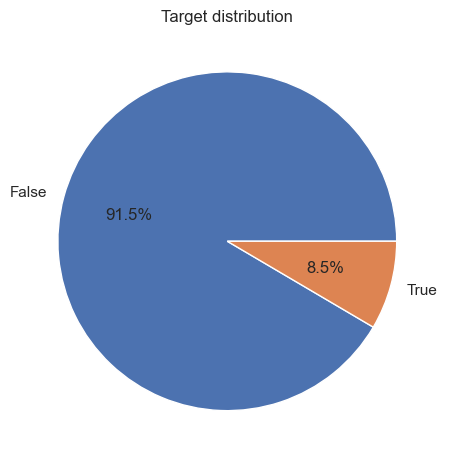

In [7]:
target_freq = train_df.target.value_counts()
plot_pie(target_freq, labels=target_freq.index, title='Target distribution', autopct='%1.1f%%')

Целевая переменная несбалансирована.

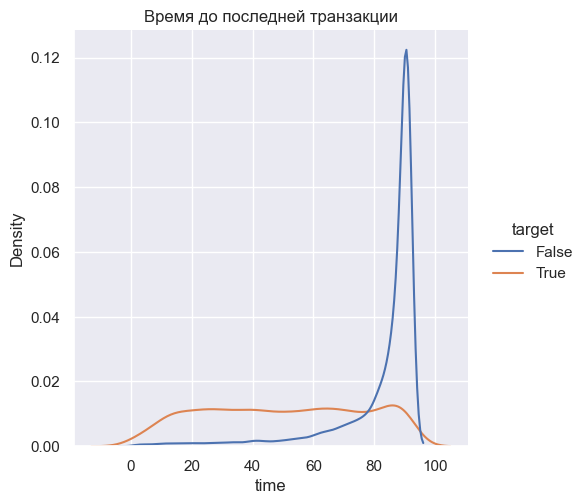

In [8]:
sns.displot(data=train_df, x='time', kind='kde', hue='target', common_norm=False)
plt.title('Время до последней транзакции');

## `clients.csv`

In [9]:
clients_df.head()

,user_id,report,employee_count_nm,bankemplstatus,customer_age
0,3,2,ОТ 101 ДО 500,False,3
1,9,1,БОЛЕЕ 1001,False,3
2,13,6,ОТ 501 ДО 1000,False,2
3,37,5,БОЛЕЕ 1001,False,2
4,41,1,ОТ 101 ДО 500,False,2


In [10]:
clients_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96000 entries, 0 to 95999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   user_id            96000 non-null  int64   
 1   report             96000 non-null  int64   
 2   employee_count_nm  59534 non-null  category
 3   bankemplstatus     96000 non-null  bool    
 4   customer_age       96000 non-null  category
dtypes: bool(1), category(2), int64(2)
memory usage: 1.7 MB


In [11]:
clients_df.employee_count_nm.unique()

['ОТ 101 ДО 500', 'БОЛЕЕ 1001', 'ОТ 501 ДО 1000', 'ДО 10', NaN, 'ОТ 11 ДО 50', 'ОТ 51 ДО 100', 'БОЛЕЕ 500', 'ОТ 11 ДО 30', 'ОТ 31 ДО 50']
Categories (9, object): ['БОЛЕЕ 1001', 'БОЛЕЕ 500', 'ДО 10', 'ОТ 101 ДО 500', ..., 'ОТ 11 ДО 50', 'ОТ 31 ДО 50', 'ОТ 501 ДО 1000', 'ОТ 51 ДО 100']

Имеется два диапазона, которые полностью составляют третий: $[11, 30]\ \text{and}\ [31, 50] \subset [11, 50]$. Также имеется пересечение диапазона $(500, \infty)$ с $[501, 1000]\ \text{and}\ (1001, \infty)$. Если его упразнять, то непонятно какому в итоге диапазону приписывать.

In [12]:
# объединим два поддиапазона в один
clients_df.loc[clients_df.employee_count_nm.isin(['ОТ 11 ДО 30', 'ОТ 31 ДО 50']), 'employee_count_nm'] = 'ОТ 11 ДО 50'

# пока что определим "БОЛЕЕ 500" как "ОТ 501 ДО 1000"
clients_df.loc[clients_df.employee_count_nm == 'БОЛЕЕ 500', 'employee_count_nm'] = 'ОТ 501 ДО 1000'

# заполним пропуски как "unknown"
clients_df['employee_count_nm'] = clients_df['employee_count_nm'].cat.add_categories('unknown')
clients_df['employee_count_nm'] = clients_df['employee_count_nm'].fillna('unknown')

# удалим лишние категории
clients_df['employee_count_nm'] = clients_df['employee_count_nm'].cat.remove_unused_categories()

# проранжируем категории
clients_df['employee_count_nm'] = clients_df['employee_count_nm'].cat.reorder_categories(
    ['ДО 10', 'ОТ 11 ДО 50', 'ОТ 51 ДО 100', 'ОТ 101 ДО 500', 'ОТ 501 ДО 1000', 'БОЛЕЕ 1001', 'unknown'], ordered=True)

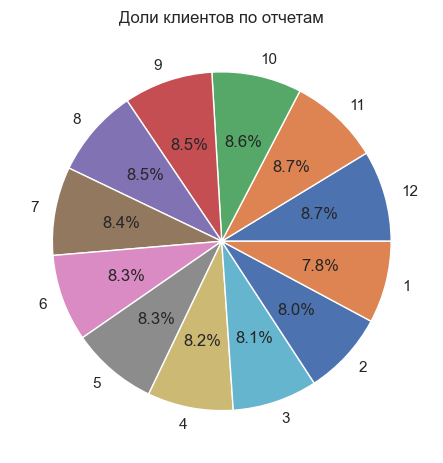

In [13]:
report_freq = clients_df.report.value_counts(normalize=True)
plot_pie(report_freq, 'Доли клиентов по отчетам', labels=report_freq.index, autopct='%1.1f%%')

In [14]:
# объединим с train_df
clients_df = clients_df.merge(train_df, on='user_id', how='left')

In [15]:
# разделим на обучающую и тестовую (для предсказания) выборки
clients_df_train = clients_df[clients_df.target.notna()]
clients_df_pred = clients_df[clients_df.target.isna()]

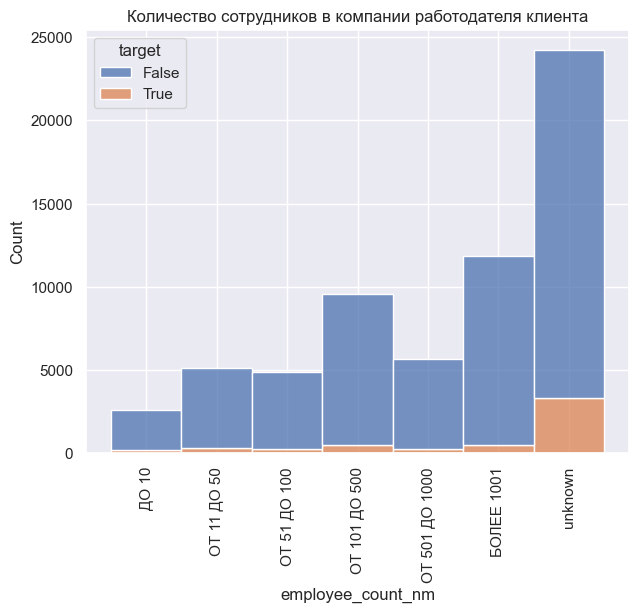

In [16]:
sns.histplot(data=clients_df_train, x='employee_count_nm', hue='target', multiple="stack")
plt.title('Количество сотрудников в компании работодателя клиента')
plt.xticks(rotation=90);

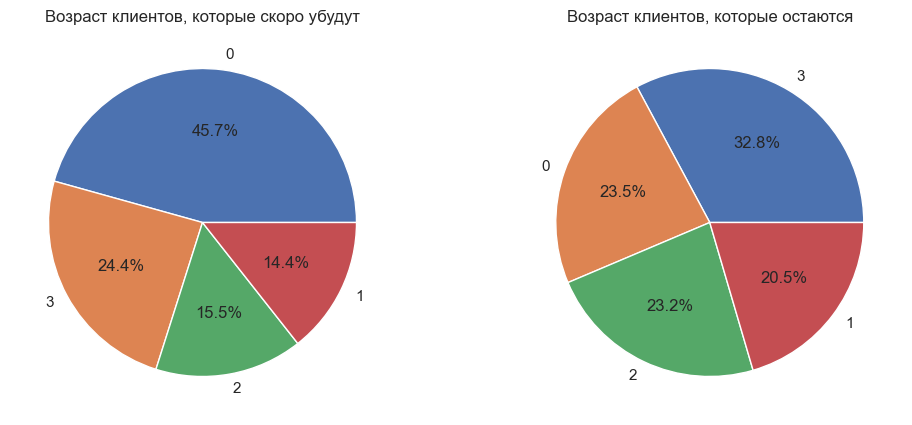

In [17]:
age_freq_true = clients_df_train.query('target == True').customer_age.value_counts()
age_freq_false = clients_df_train.query('target == False').customer_age.value_counts()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].pie(age_freq_true, labels=age_freq_true.index, autopct='%1.1f%%')
ax[0].set_title('Возраст клиентов, которые скоро убудут')

ax[1].pie(age_freq_false, labels=age_freq_false.index, autopct='%1.1f%%')
ax[1].set_title('Возраст клиентов, которые остаются');

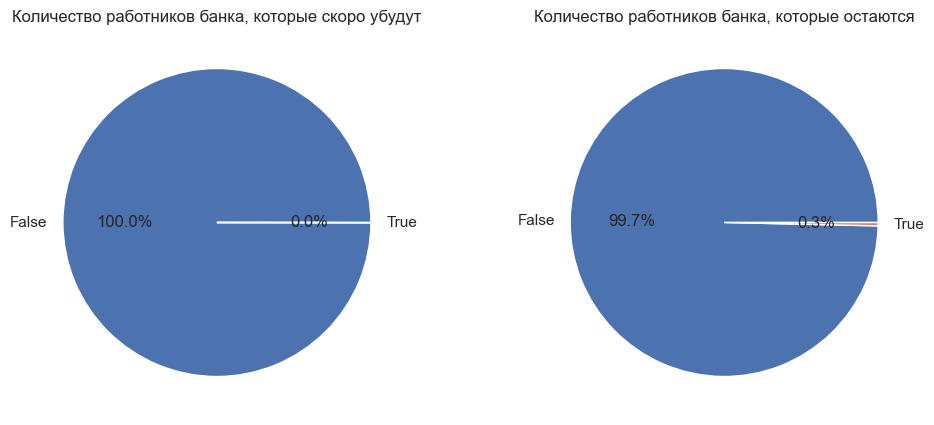

In [18]:
bankemplstatus_freq_true = clients_df_train.query('target == True').bankemplstatus.value_counts()
bankemplstatus_freq_false = clients_df_train.query('target == False').bankemplstatus.value_counts()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].pie(bankemplstatus_freq_true, labels=bankemplstatus_freq_true.index, autopct='%1.1f%%')
ax[0].set_title('Количество работников банка, которые скоро убудут')

ax[1].pie(bankemplstatus_freq_false, labels=bankemplstatus_freq_false.index, autopct='%1.1f%%')
ax[1].set_title('Количество работников банка, которые остаются');

## `report_dates.csv`

In [19]:
reports_df.head()

,report,report_dt
0,1,2022-07-31 03:00:00
1,2,2022-08-31 03:00:00
2,3,2022-09-30 03:00:00
3,4,2022-10-31 03:00:00
4,5,2022-11-30 03:00:00


In [20]:
reports_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   report     12 non-null     int64         
 1   report_dt  12 non-null     datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 320.0 bytes


In [21]:
reports_df.report_dt = pd.to_datetime(reports_df.report_dt)

## `transactions.csv`

In [22]:
transactions_df.head()

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm
0,3,3,1,-183.883957,2022-01-28 12:05:33
1,3,3,1,-3206.437012,2022-01-28 12:52:30
2,3,16,1,-153866.890625,2022-02-16 14:45:56
3,3,56,1,-15144.601562,2022-03-09 19:58:29
4,3,0,1,5297.908691,2022-03-12 18:11:31


In [23]:
# объединим с train_df
transactions_df = transactions_df.merge(train_df, on='user_id', how='left')

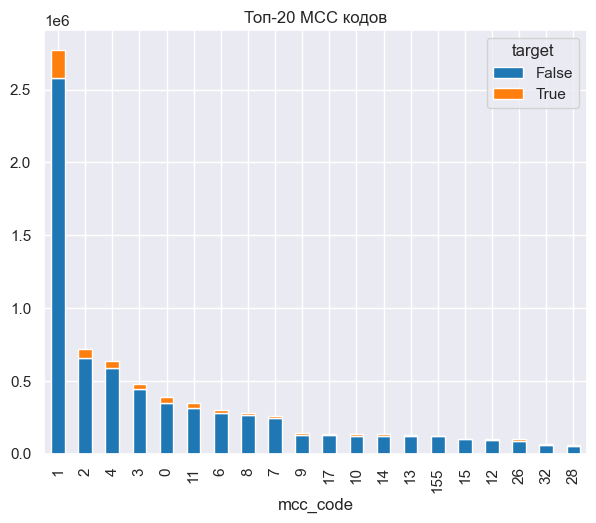

In [24]:
# посмотрим на самые частые mcc коды
top_20_mcc = transactions_df.mcc_code.value_counts()[:20].index

tran_top_20_mcc = transactions_df[transactions_df.mcc_code.isin(top_20_mcc)]
tran_top_20_mcc['mcc_code'] = tran_top_20_mcc['mcc_code'].cat.remove_unused_categories()
tran_top_20_mcc_freq = tran_top_20_mcc.groupby(['target', 'mcc_code'], as_index=False).user_id.count()\
                                      .rename(columns={'user_id': 'count'}).sort_values(by='count', ascending=False)

tran_top_20_mcc_freq.target = tran_top_20_mcc_freq.target.astype('str')

tran_top_20_mcc_freq.pivot_table(index='mcc_code', columns='target', values='count', aggfunc='sum').sort_values(by='False', ascending=False)\
                    .plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'], title='Топ-20 MCC кодов');

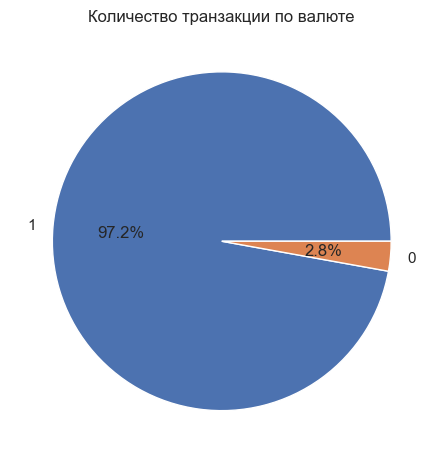

In [25]:
# посмотрим на частоты currency_rk
currency_rk_freq = transactions_df.currency_rk.value_counts(normalize=True)
currency_rk_most_freq = currency_rk_freq[currency_rk_freq > 0.01]

plot_pie(currency_rk_most_freq, 'Количество транзакции по валюте', labels=currency_rk_most_freq.index, autopct='%1.1f%%')

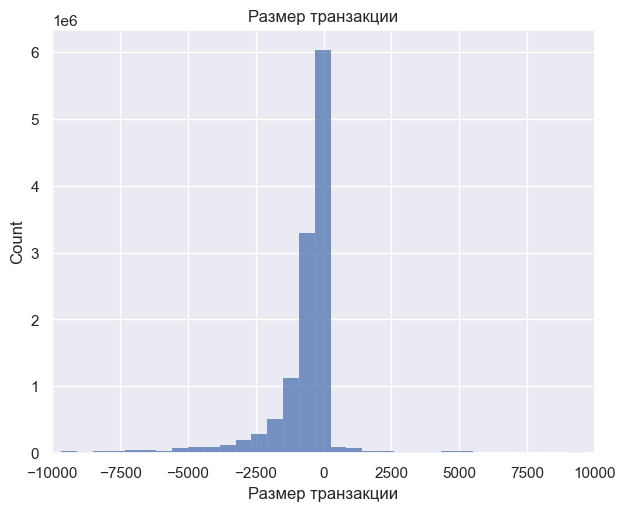

In [31]:
sns.histplot(data=transactions_df, x='transaction_amt', bins=1000)
plt.title('Размер транзакции')
plt.xlim(-10000, 10000)
plt.xlabel('Размер транзакции');